Loading libraries

In [2]:
library(dplyr)
library(patchwork)
library(Seurat)
library(ggplot2)
library(sctransform)
library(cowplot)
library(limma)
library(rbokeh)
library(dittoSeq)

library(purrr)
library(pheatmap)
library(viridis)
library(ggrepel)
library(grDevices)
library(rbokeh)
source("scripts/seurat_helpers.R")
library(gridExtra)

library(pagoda2)
library(igraph)
library(ggthemes)

library(svglite)
library(extrafont)

Loading data and creating the Seurat objects. Cells that have less then 200 detected genes are discarded. Genes that are expressed in at least 3 cells are kept. 

In [3]:
# Load the datasets
wtF.data <- Read10X(data.dir = "Rik_WT_f_cellranger/filtered_feature_bc_matrix/")
mutF.data <- Read10X(data.dir = "Rik_mut_F_cellranger/filtered_feature_bc_matrix/")
mutM.data <- Read10X(data.dir = "Rik_mut_m_cellranger/filtered_feature_bc_matrix/")
mut.data <- Read10X(data.dir = "/home/irina/RIK/RIK_11.20/mut/counts/filtered_feature_bc_matrix/")
wt.data <- Read10X(data.dir = "/home/irina/RIK/RIK_11.20/WT/counts/filtered_feature_bc_matrix/")

# Initialize the Seurat objects with the raw (non-normalized) data. 

wtF <- CreateSeuratObject(counts = wtF.data, project = "RIK_wtF", min.cells = 3, min.features = 200)
mutF <- CreateSeuratObject(counts = mutF.data, project = "RIK_mutF", min.cells = 3, min.features = 200)
mutM <- CreateSeuratObject(counts = mutM.data, project = "RIK_mutM", min.cells = 3, min.features = 200)
mut3 <- CreateSeuratObject(counts = mut.data, project = "RIK_mut.3", min.cells = 3, min.features = 200)
wt3 <- CreateSeuratObject(counts = wt.data, project = "RIK_wt.3", min.cells = 3, min.features = 200)


A doublet prediction with Scrublet

In [ ]:
##
doublets_col <- function(sample) {
    mat <- sample@assays[["RNA"]]@counts
    # get scores from scrublet
    doublet_scores <- get.scrublet.scores(mat)
    sample@meta.data$doublet_score <- doublet_scores
    sample
}

wtF <- doublets_col(wtF)
mutF <- doublets_col(mutF)
mutM <- doublets_col(mutM)
wt3 <- doublets_col(wt3)
mut3 <- doublets_col(mut3)

Adding the description and renaming cells

In [4]:
wtF$type <- "wt"
mutF$type <- "mut"
mutM$type <- "mut"
wt3$type <- "wt"
mut3$type <- "mut"

wtF <- RenameCells(wtF, add.cell.id = "wtF")
mutF <- RenameCells(mutF, add.cell.id = "mutF")
mutM <- RenameCells(mutM, add.cell.id = "mutM")
wt3 <- RenameCells(wt3, add.cell.id = "wt3")
mut3 <- RenameCells(mut3, add.cell.id = "mut3")

Filtering

In [5]:
sample.list <- list(wtF, mutF, mutM, wt3, mut3)

sample.list <- lapply(X = sample.list, FUN = function(x) {
    x[["percent.mt"]] <- PercentageFeatureSet(x, pattern = "^mt-")
    x <- subset(x, subset = nCount_RNA > 1000 & percent.mt < 50)
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

Intergration: identifying anchors and using these anchors to integrate the two datasets together with IntegrateData.

In [6]:
RIK.anchors <- FindIntegrationAnchors(object.list = sample.list, dims = 1:20)
RIK.combined <- IntegrateData(anchorset = RIK.anchors, dims = 1:20)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6445 anchors

Filtering anchors

	Retained 4543 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4986 anchors

Filtering anchors

	Retained 3728 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5168 anchors

Filtering anchors

	Retained 3514 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5386 anchors

Filtering anchors

	Retained 2442 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5923 anchors

Filtering anchors

	Retained 2425 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4889 anchors

Filtering anchors

	Retained 2796 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5390 anchors


PCA, UMAP embedding and clustering

In [7]:
DefaultAssay(RIK.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
RIK.combined <- ScaleData(RIK.combined, vars.to.regress = "percent.mt", verbose = FALSE)
RIK.combined <- RunPCA(RIK.combined, npcs = 40, verbose = FALSE)

RIK.combined <- RunUMAP(RIK.combined, n.neighbors = 30, reduction = "pca", dims = 1:40)

RIK.combined <- FindNeighbors(RIK.combined,  reduction = "umap", dims = 1:2)
RIK.combined <- FindClusters(RIK.combined, resolution = 0.1)


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:38:22 UMAP embedding parameters a = 0.9922 b = 1.112

09:38:22 Read 14222 rows and found 40 numeric columns

09:38:22 Using Annoy for neighbor search, n_neighbors = 30

09:38:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:38:24 Writing NN index file to temp file /tmp/Rtmp5swPO1/file80d61ec6b545

09:38:24 Searching Annoy index using 1 thread, search_k = 3000

09:38:29 Annoy recall = 100%

09:38:30 Commencing smooth kNN distance calibration using 1 thread

09:38:32 Initializing fr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14222
Number of edges: 309337

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9829
Number of communities: 20
Elapsed time: 0 seconds


In [9]:
load('RIK_merged_cl25_cells.rds') #list of doublet cells
load('RIK_merged_T_cells.rds') # list of T-cells and NK-cells from RBC cluster

In [10]:
#remove cells from cl25
RIK.combined <- RIK.combined[,!colnames(RIK.combined) %in% cl25_cells]

In [13]:
RIK.combined

An object of class Seurat 
19389 features across 14197 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [11]:
# export T-cells from RBC cluster
RIK.combined[["my.clusters"]] <- Idents(object = RIK.combined)
RIK.combined$my.clusters <- as.character(RIK.combined$my.clusters)
RIK.combined$my.clusters[T_cells] <- "T cells/NK cells"

RIK.combined$my.clusters <- as.factor(RIK.combined$my.clusters)
Idents(object = RIK.combined) <- RIK.combined[["my.clusters"]]


In [12]:
RIK.combined <- RenameIdents(RIK.combined, `0` = "PT_s", `1` = "PT_1", `2` = "PT_c", 
    `3` = "PT_2", `4` = "LOH", `5` = "RBC", `6` = "GL_endo", `7` = "DCT", 
    `8` = "CD_PC", `9` = "CD_IC/CD_Trans", `10` = "myeloid cells", `11` = "PT_f",
    `12` = "VSMC",  `13` = "Juxt_ldl_LOH", `14` = "GL_sc", `15` = "PE", `16` = "Fib", 
    `17` = "GL_podo", `T cells/NK cells` = "T cells/NK cells")

#PT: proximal tubule, LOH: loop of henle, DCT: distal convoluted tubule, CD: collecting duct, RBC - red blood cells
# PT_c - proxymal convoluted tubules (segment S1), PT_s - proxymal straight tubule, PT_f - female specific cells from segment S3
# GL_endothelial
# VSMC = mesangial cells?
# GL_ep - mix of endothelial cells, pericytes and podocytes in glomeruli
# GL_ic - interstitial cells (stromal (fibroblasts) and VSMC) of glomeruli 
# GL_sc - suspected stem cells
# Juxt_ldl_LOH - Juxtamedullary nephrons, Long descending limb of the loop of Henle
# PE - Parietal epithelium in glomerulli (well the upper part of the cluster, the lower part came from RIK_wtF and wtf)


Warning message:
“Cannot find identity T cells/NK cells”


In [22]:
RIK.combined$seurat_clusters <- Idents(object = RIK.combined)

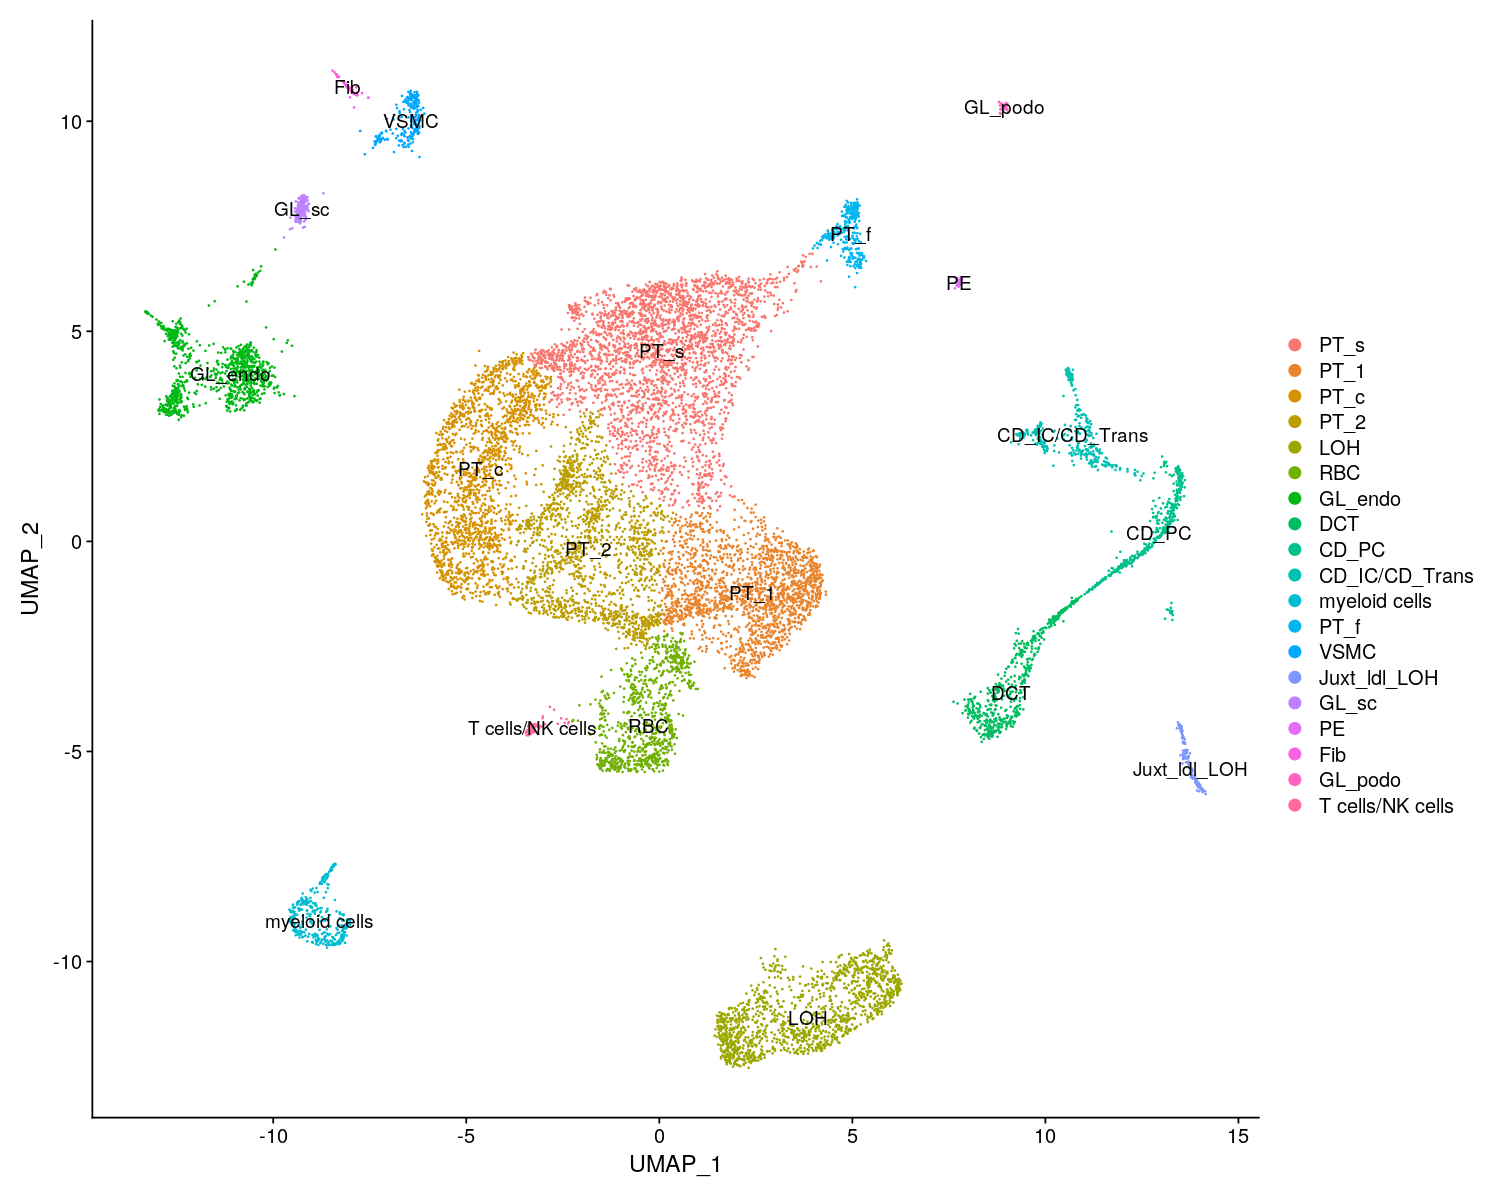

In [23]:
## set universal plot size:
options(repr.plot.width=12.5, repr.plot.height=10)
DimPlot(RIK.combined, label = TRUE)

Finding the markers for every cluster compared to all remaining cells, report only the positive ones

In [25]:
DefaultAssay(RIK.combined) <- "RNA"
all.markers <- FindAllMarkers(RIK.combined, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster PT_s

Calculating cluster PT_1

Calculating cluster PT_c

Calculating cluster PT_2

Calculating cluster LOH

Calculating cluster RBC

Calculating cluster GL_endo

Calculating cluster DCT

Calculating cluster CD_PC

Calculating cluster CD_IC/CD_Trans

Calculating cluster myeloid cells

Calculating cluster PT_f

Calculating cluster VSMC

Calculating cluster Juxt_ldl_LOH

Calculating cluster GL_sc

Calculating cluster PE

Calculating cluster Fib

Calculating cluster GL_podo

Calculating cluster T cells/NK cells



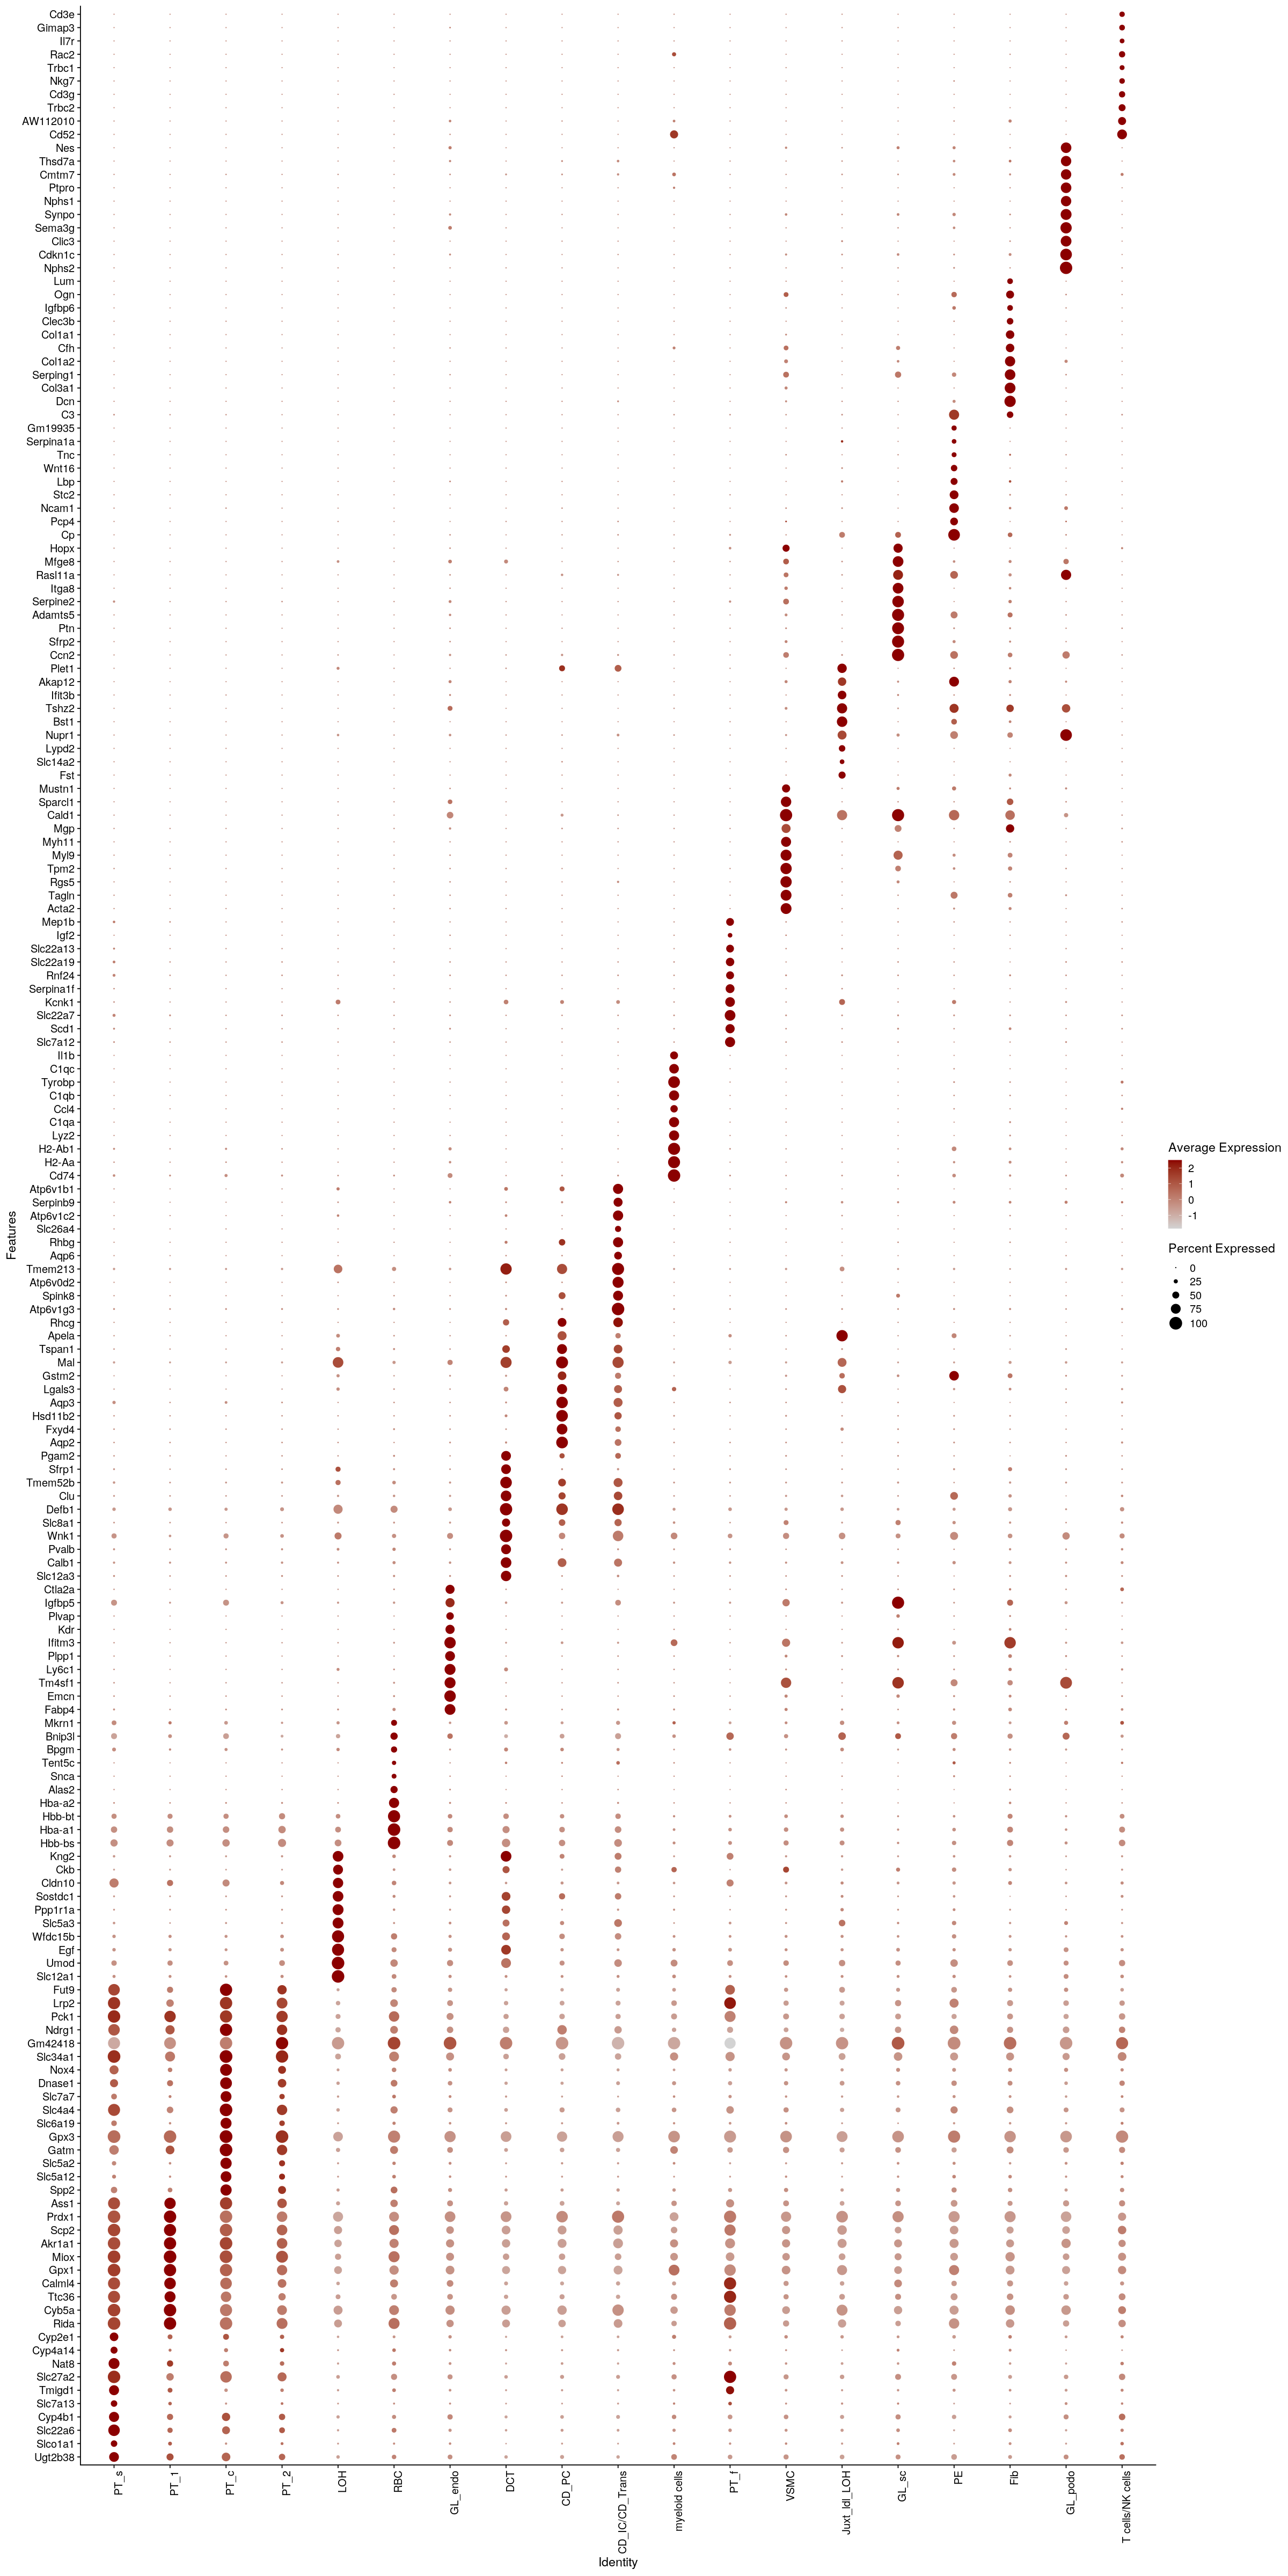

In [27]:
clusters <- c("PT_s", "PT_1", "PT_c", "PT_2", "LOH", "RBC", "GL_endo", "DCT", "CD_PC", "CD_IC/CD_Trans", "myeloid cells", "PT_f",
"VSMC",  "Juxt_ldl_LOH", "GL_sc", "PE", "Fib", "GL_podo", "T cells/NK cells")

gene_marker_table <- function(x){all.markers[all.markers$cluster == x, ] %>% head(n=10)}
top10_markers <- map_dfr(clusters, gene_marker_table)

options(repr.plot.width=20, repr.plot.height=40)

DotPlot(RIK.combined, features = unique(top10_markers$gene), cols = c("lightgrey", "darkred"))+
         coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

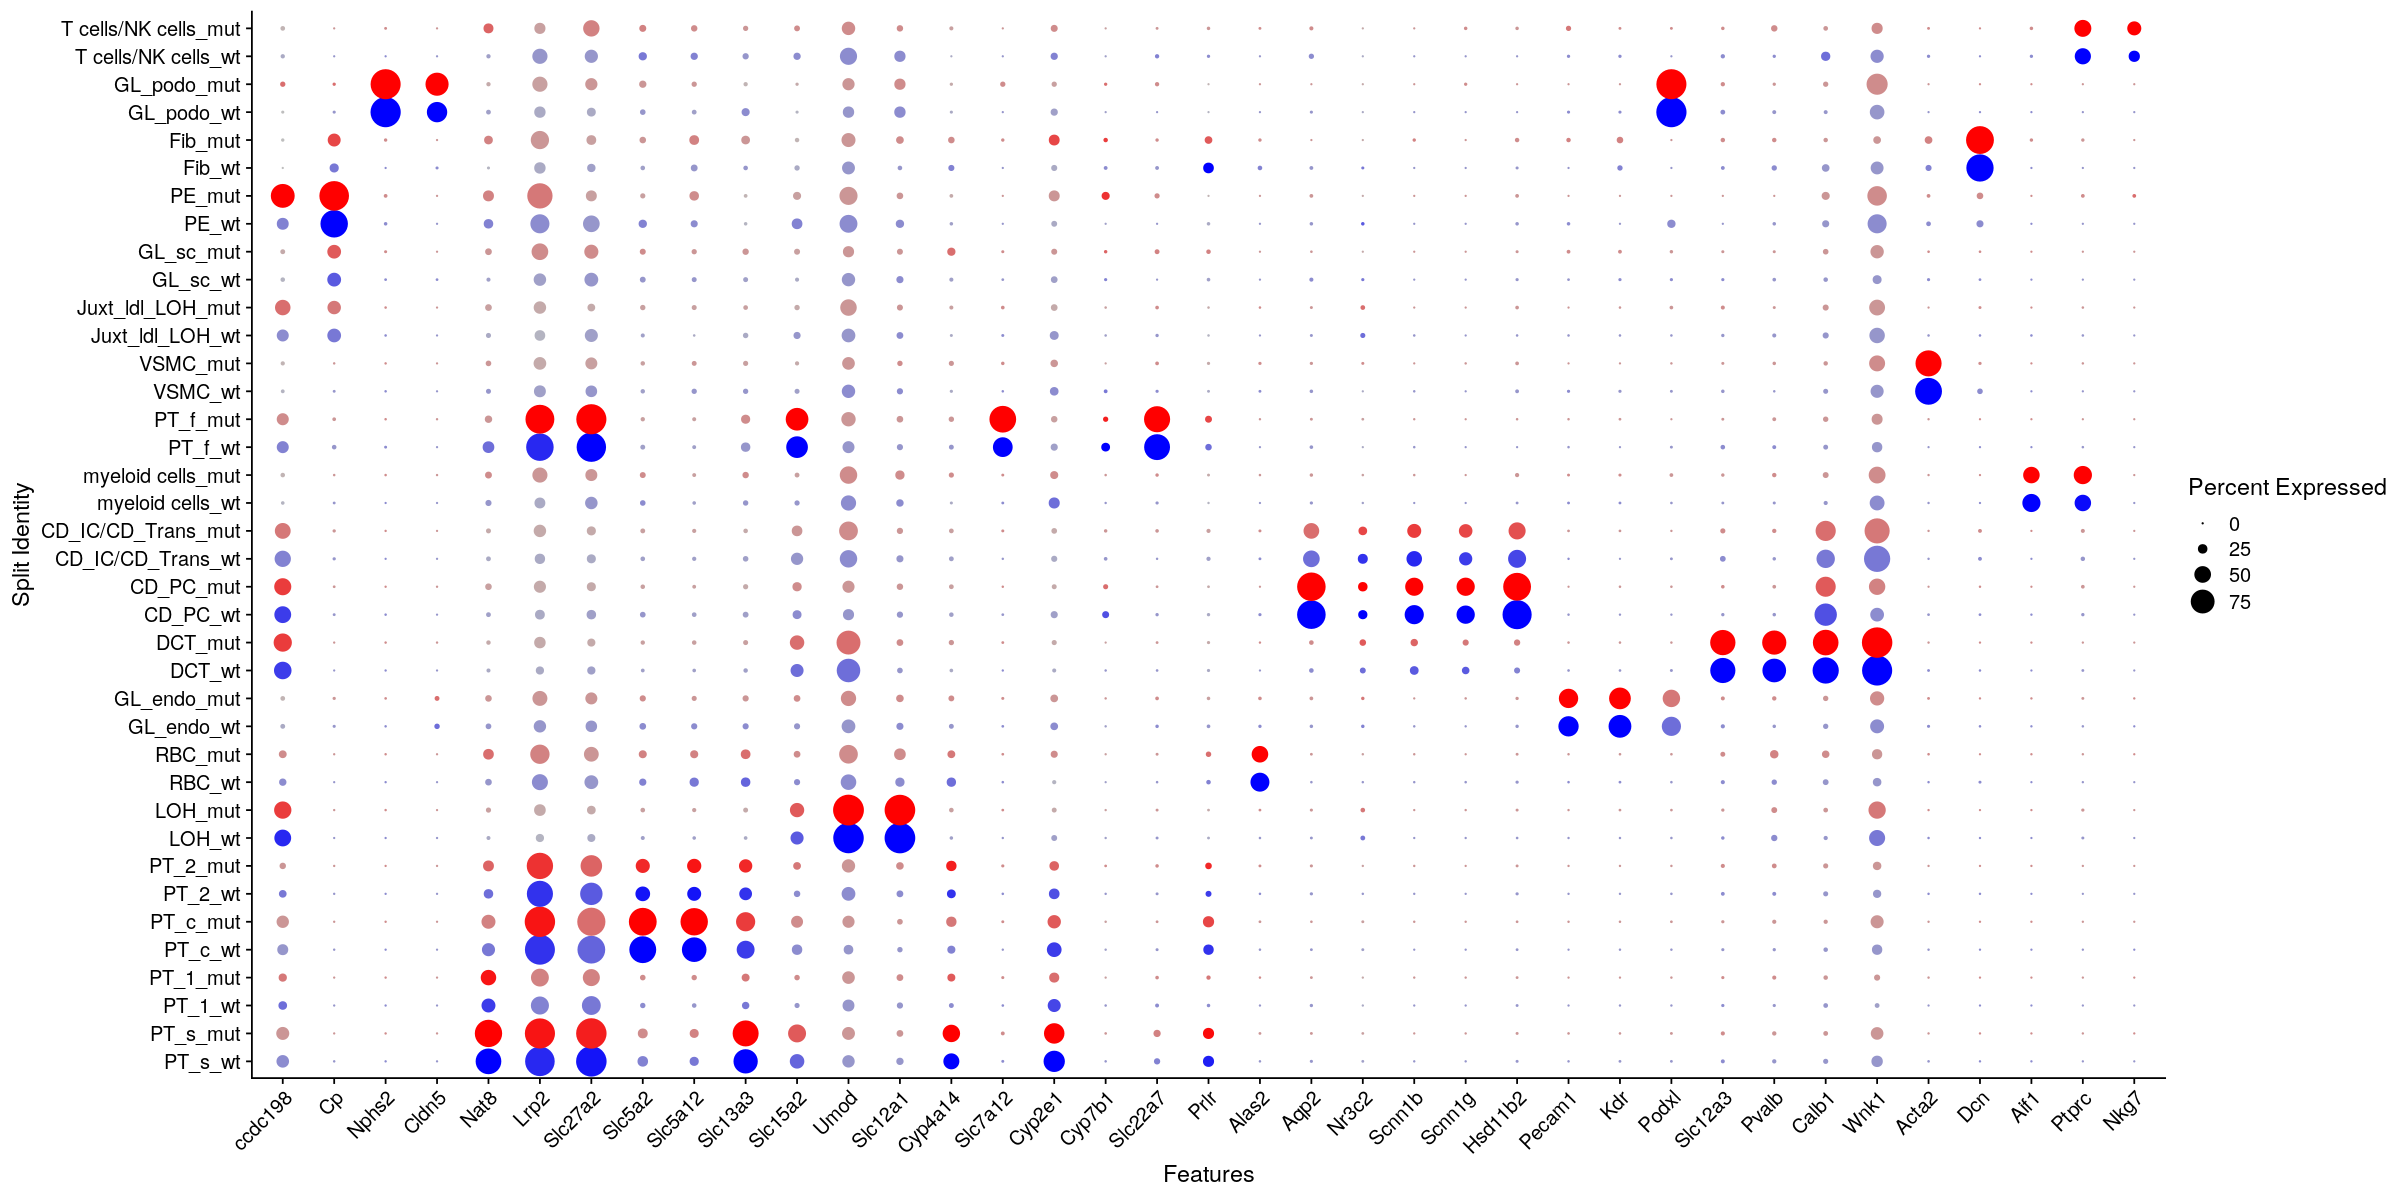

In [28]:
## set universal plot size:
options(repr.plot.width=20, repr.plot.height=10)

cluster_names <- c("PT_s", "PT_1", "PT_c", "PT_2", "LOH", "RBC", "GL_endo", "DCT", "CD_PC", "CD_IC/CD_Trans", "myeloid cells", "PT_f",
"VSMC",  "Juxt_ldl_LOH", "GL_sc", "PE", "Fib", "GL_podo", "T cells/NK cells")

Idents(RIK.combined) <- factor(Idents(RIK.combined), levels = cluster_names)

markers.to.plot <- c("ccdc198", "Cp", "Nphs2", "Cldn5", "Nat8", "Lrp2", "Slc27a2", "Slc5a2", "Slc5a12",  "Slc13a3", "Slc15a2", "Umod", "Slc12a1", 
                  "Cyp4a14", "Slc7a12", "Cyp2e1", "Cyp7b1", "Slc22a7", "Prlr", 
                  "Alas2", "Aqp2", "Nr3c2", "Scnn1b", "Scnn1g", "Hsd11b2", "Pecam1",
                  "Kdr", "Podxl", "Slc12a3", "Pvalb", "Calb1", "Wnk1", "Acta2", "Dcn", "Aif1", "Ptprc", "Nkg7")

DotPlot(RIK.combined, features = markers.to.plot, cols = c("blue", "red"), dot.scale = 8, split.by = "type") + 
    RotatedAxis()

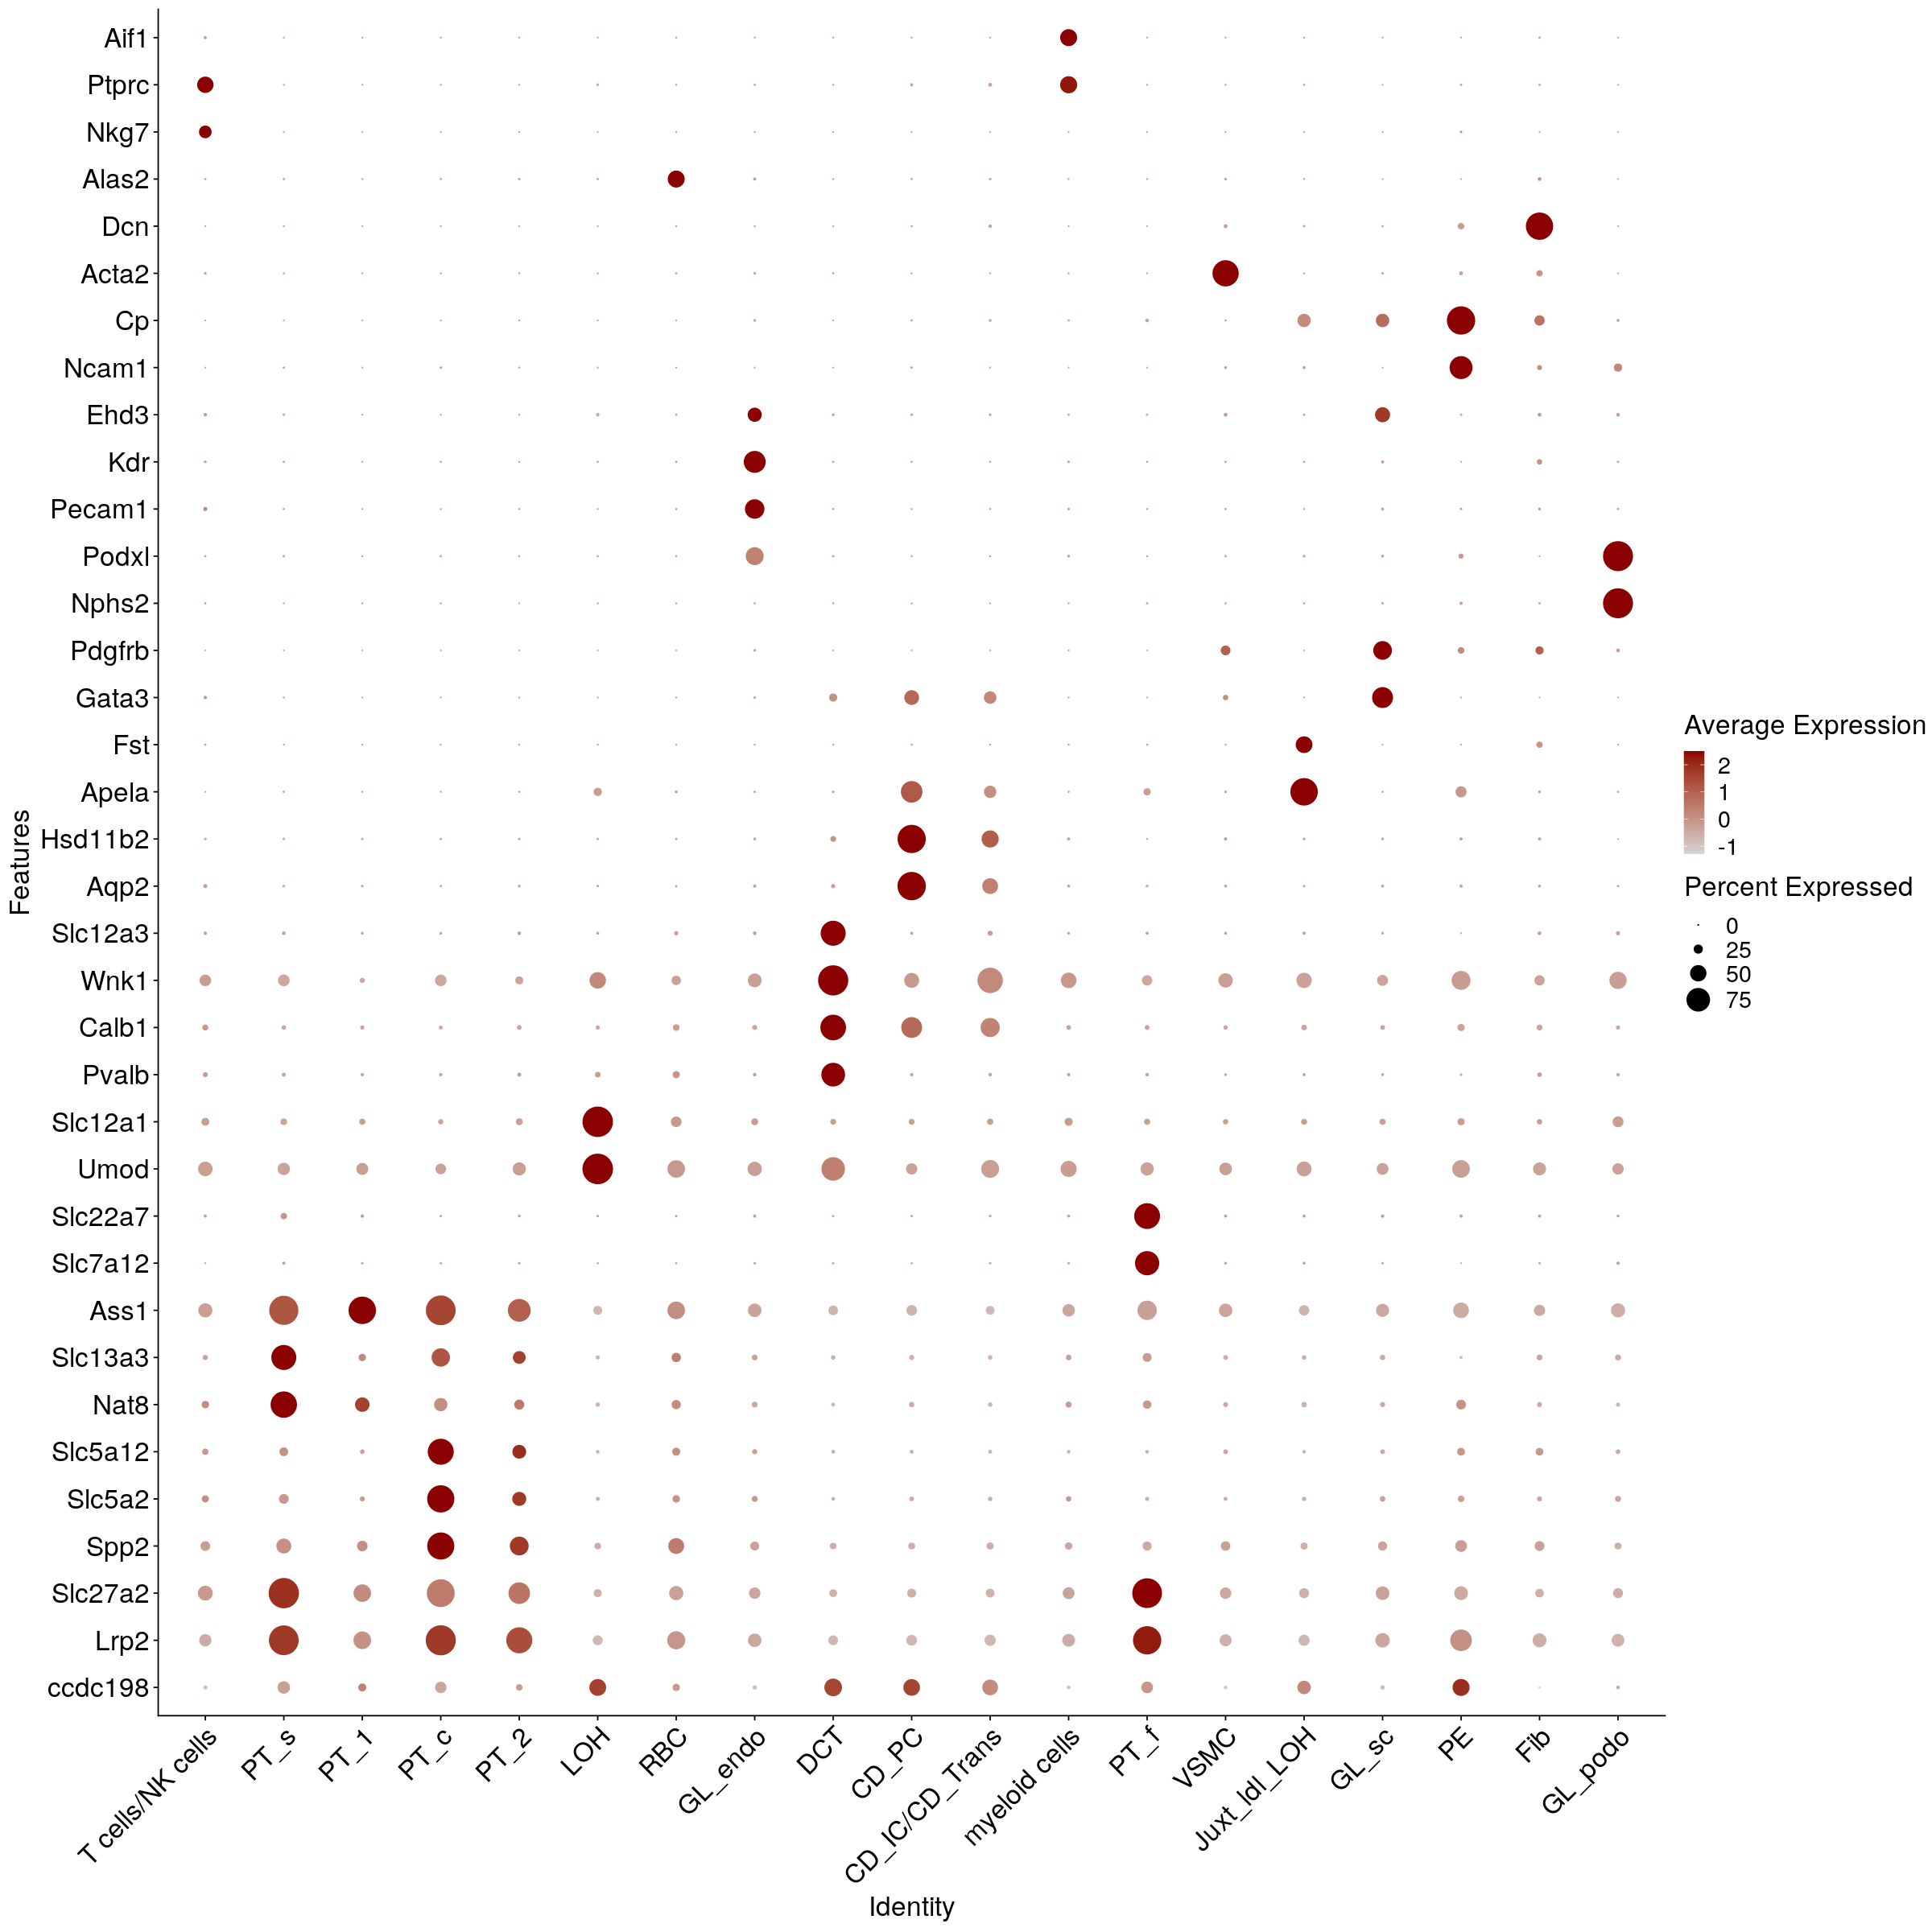

In [35]:
options(repr.plot.width=20, repr.plot.height=20)
DefaultAssay(RIK.combined) <- "RNA"
many_markers <- c("Lrp2", "Slc27a2", "Spp2", "Slc5a2", "Slc5a12", "Nat8", "Slc13a3", "Ass1",  
                  "Slc7a12", "Slc22a7", "Umod", "Slc12a1", 
                  "Pvalb", "Calb1", "Wnk1", "Slc12a3", "Aqp2", "Hsd11b2", "Apela", "Fst", "Gata3",
                  "Pdgfrb", "Nphs2", "Podxl", "Pecam1", "Kdr", "Ehd3", "Ncam1",
                  "Cp", "Acta2",  "Dcn", "Alas2", "Nkg7", "Ptprc", "Aif1")
DotPlot(RIK.combined, features = c("ccdc198", many_markers), cols = c("lightgrey", "darkred"), dot.scale = 10) +
         coord_flip() + theme(axis.text.y = element_text(size = 20), axis.text.x = element_text(size = 20, angle = 45, hjust = 1)) + 
         theme(text = element_text(size = 20))

Estimating the difference between wildtype and KO

In [36]:
table (Idents(RIK.combined))


T cells/NK cells             PT_s             PT_1             PT_c 
              78             2958             1867             1812 
            PT_2              LOH              RBC          GL_endo 
            1615             1384              873              940 
             DCT            CD_PC   CD_IC/CD_Trans    myeloid cells 
             554              445              354              340 
            PT_f             VSMC     Juxt_ldl_LOH            GL_sc 
             275              218              168              143 
              PE              Fib          GL_podo 
              44               65               64 

In [37]:
RIK.combined[["my.clusters"]] <- Idents(object = RIK.combined)
table(RIK.combined@meta.data$my.clusters, RIK.combined@meta.data$type)

                  
                    mut   wt
  T cells/NK cells   49   29
  PT_s             1631 1327
  PT_1             1069  798
  PT_c             1040  772
  PT_2              996  619
  LOH               853  531
  RBC               628  245
  GL_endo           518  422
  DCT               339  215
  CD_PC             249  196
  CD_IC/CD_Trans    204  150
  myeloid cells     182  158
  PT_f              186   89
  VSMC              122   96
  Juxt_ldl_LOH       85   83
  GL_sc              78   65
  PE                 20   24
  Fib                27   38
  GL_podo            29   35

In [38]:
get.contigency_tables <- function(object.table, cluster_name) {
    # write out a CSV file
    
    table_transposed <- t(object.table)
    in.cluster <- table_transposed[, cluster_name]
    
    out.cluster <- rowSums(table_transposed) - in.cluster
    
    df <- data.frame(in.cluster, out.cluster)
    names(df) <- c('in.cluster', 'out.cluster')
    t(df)
}

In [39]:
a <- table(RIK.combined@meta.data$my.clusters, RIK.combined@meta.data$type)

In [40]:
clusters <- c("PT_s", "PT_1", "PT_c", "PT_2", "LOH", "RBC", "GL_endo", "DCT", "CD_PC", "CD_IC/CD_Trans", "myeloid cells", "PT_f",
"VSMC",  "Juxt_ldl_LOH", "GL_sc", "PE", "Fib", "GL_podo", "T cells/NK cells")

p.values <- c()
for(cluster in clusters){
    con_table <- get.contigency_tables(a, cluster)
    fisher_results <- fisher.test(con_table)
    p.values <- c(p.values, fisher_results$p.value)
}

df_compo <- data.frame(clusters, p.values)
names(df_compo) <- c('clusters', 'p-value')
df_compo

clusters         p-value     
1  PT_s             3.282857e-05
2  PT_1             2.464118e-01
3  PT_c             3.074234e-01
4  PT_2             6.207995e-03
5  LOH              1.351449e-02
6  RBC              2.142819e-17
7  GL_endo          3.090013e-02
8  DCT              2.021372e-01
9  CD_PC            2.822637e-01
10 CD_IC/CD_Trans   7.433382e-01
11 myeloid cells    6.588630e-02
12 PT_f             1.955401e-03
13 VSMC             4.468999e-01
14 Juxt_ldl_LOH     4.042018e-02
15 GL_sc            3.487296e-01
16 PE               9.167503e-02
17 Fib              7.573576e-03
18 GL_podo          4.110390e-02
19 T cells/NK cells 4.900267e-01

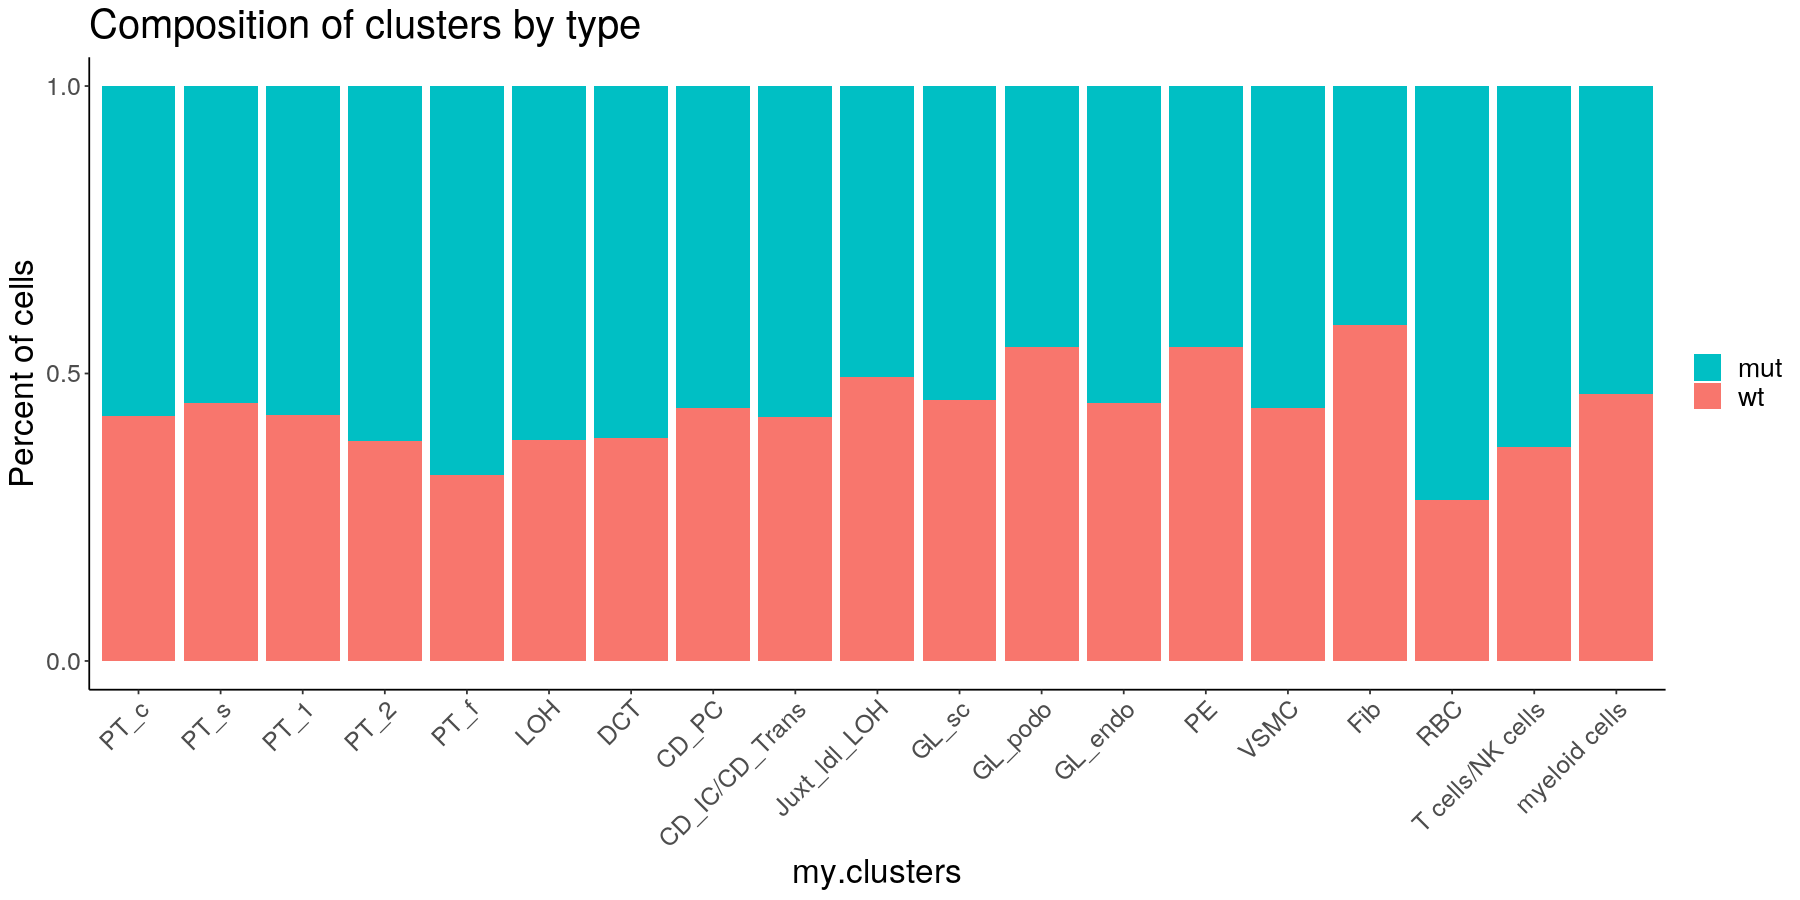

In [41]:
options(repr.plot.width=15, repr.plot.height=7.5)
dittoBarPlot(RIK.combined, "type", main = "Composition of clusters by type", group.by = "my.clusters", x.reorder = c(14, 16, 12, 13, 15, 9, 3, 2, 1, 8, 7, 6, 5, 11, 19, 4, 17, 18, 10), color.panel = c("#00BFC4", "#F8766D")) +theme(text = element_text(size = 20)) +  theme(axis.text.y = element_text(size = 15), axis.text.x = element_text(size = 15, angle = 45, hjust = 1)) 

Visualizing

In [42]:
RIK.combined$my.clusters <- factor(RIK.combined$my.clusters, levels=c('PT_c', 'PT_s', 'PT_1', 'PT_2', 'PT_f', 'LOH', 'DCT', 'CD_PC', 'CD_IC/CD_Trans', 'Juxt_ldl_LOH', 'GL_sc', 'GL_podo', 'GL_endo', 'PE', 'VSMC', 'Fib', 'RBC', 'T cells/NK cells', 'myeloid cells'))

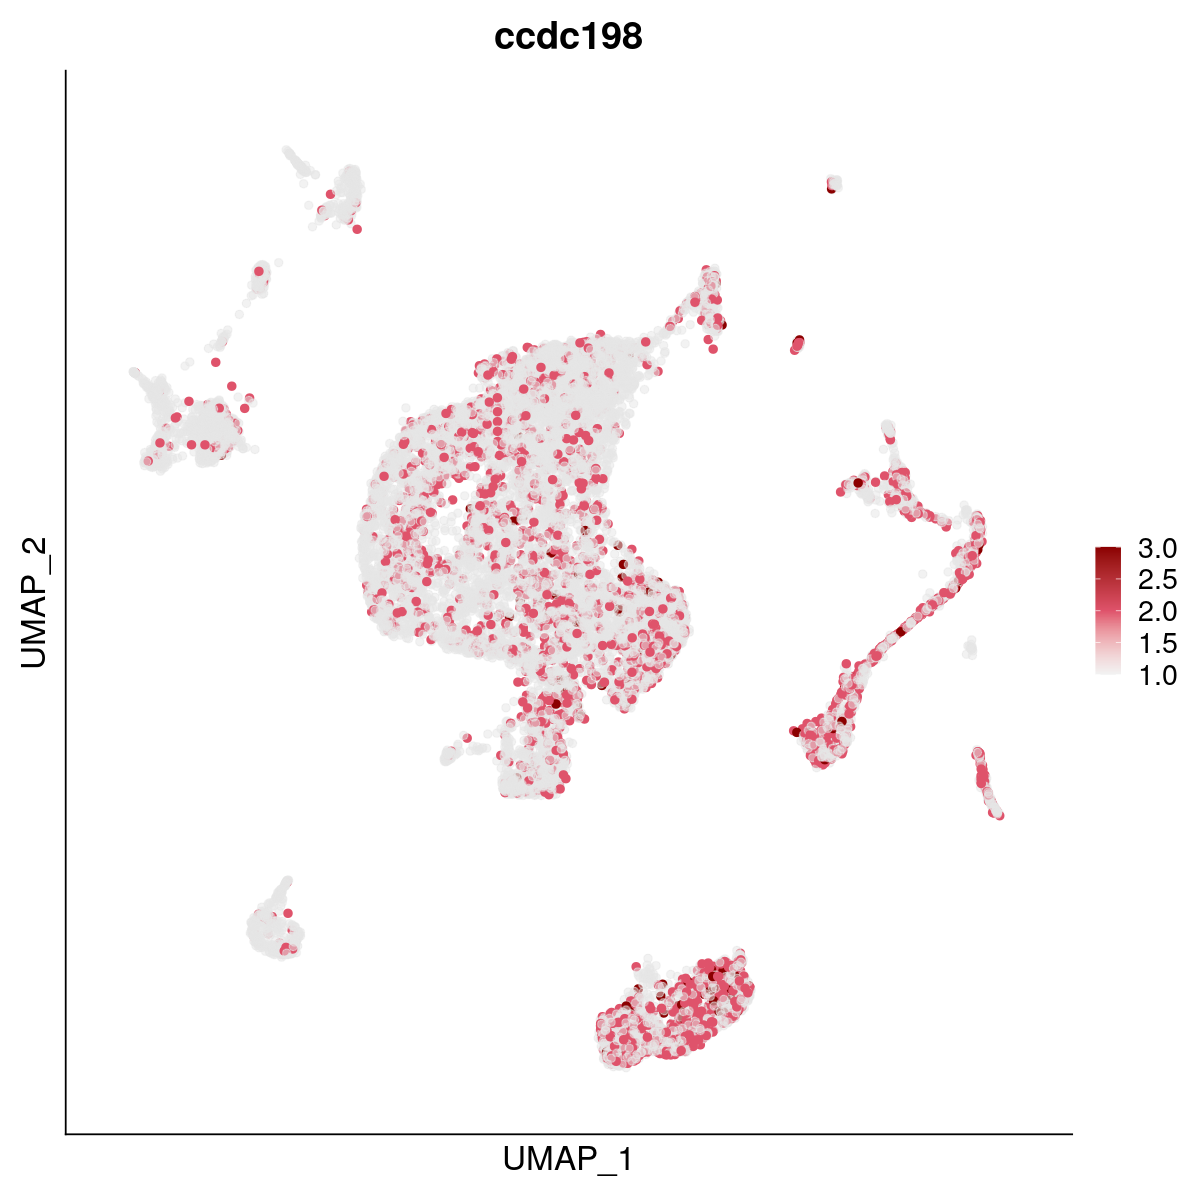

In [45]:
options(repr.plot.width = 10, repr.plot.height = 10)
FeaturePlot(RIK.combined, features = c("ccdc198"), cols = c(rgb(0.9, 0.9, 0.9, alpha = 0.5), 2, "darkred"), pt = 2) +
         theme(axis.ticks.y = element_blank(), axis.ticks.x = element_blank(),
               axis.text = element_blank()) + 
         theme(text = element_text(size = 20)) 

DimPlot(RIK.combined, reduction = "umap", label = TRUE) + theme(text = element_text(size = 20),  axis.text = element_blank()) +
        scale_color_tableau("Tableau 20")


In [46]:
options(repr.plot.width = 20, repr.plot.height = 10)
DimPlot(RIK.combined, reduction = "umap", split.by = "type", combine = TRUE) + 
                      theme(text = element_text(size = 12),  axis.text = element_blank()) +
                      theme(legend.position = 'none') + scale_color_tableau("Tableau 20")

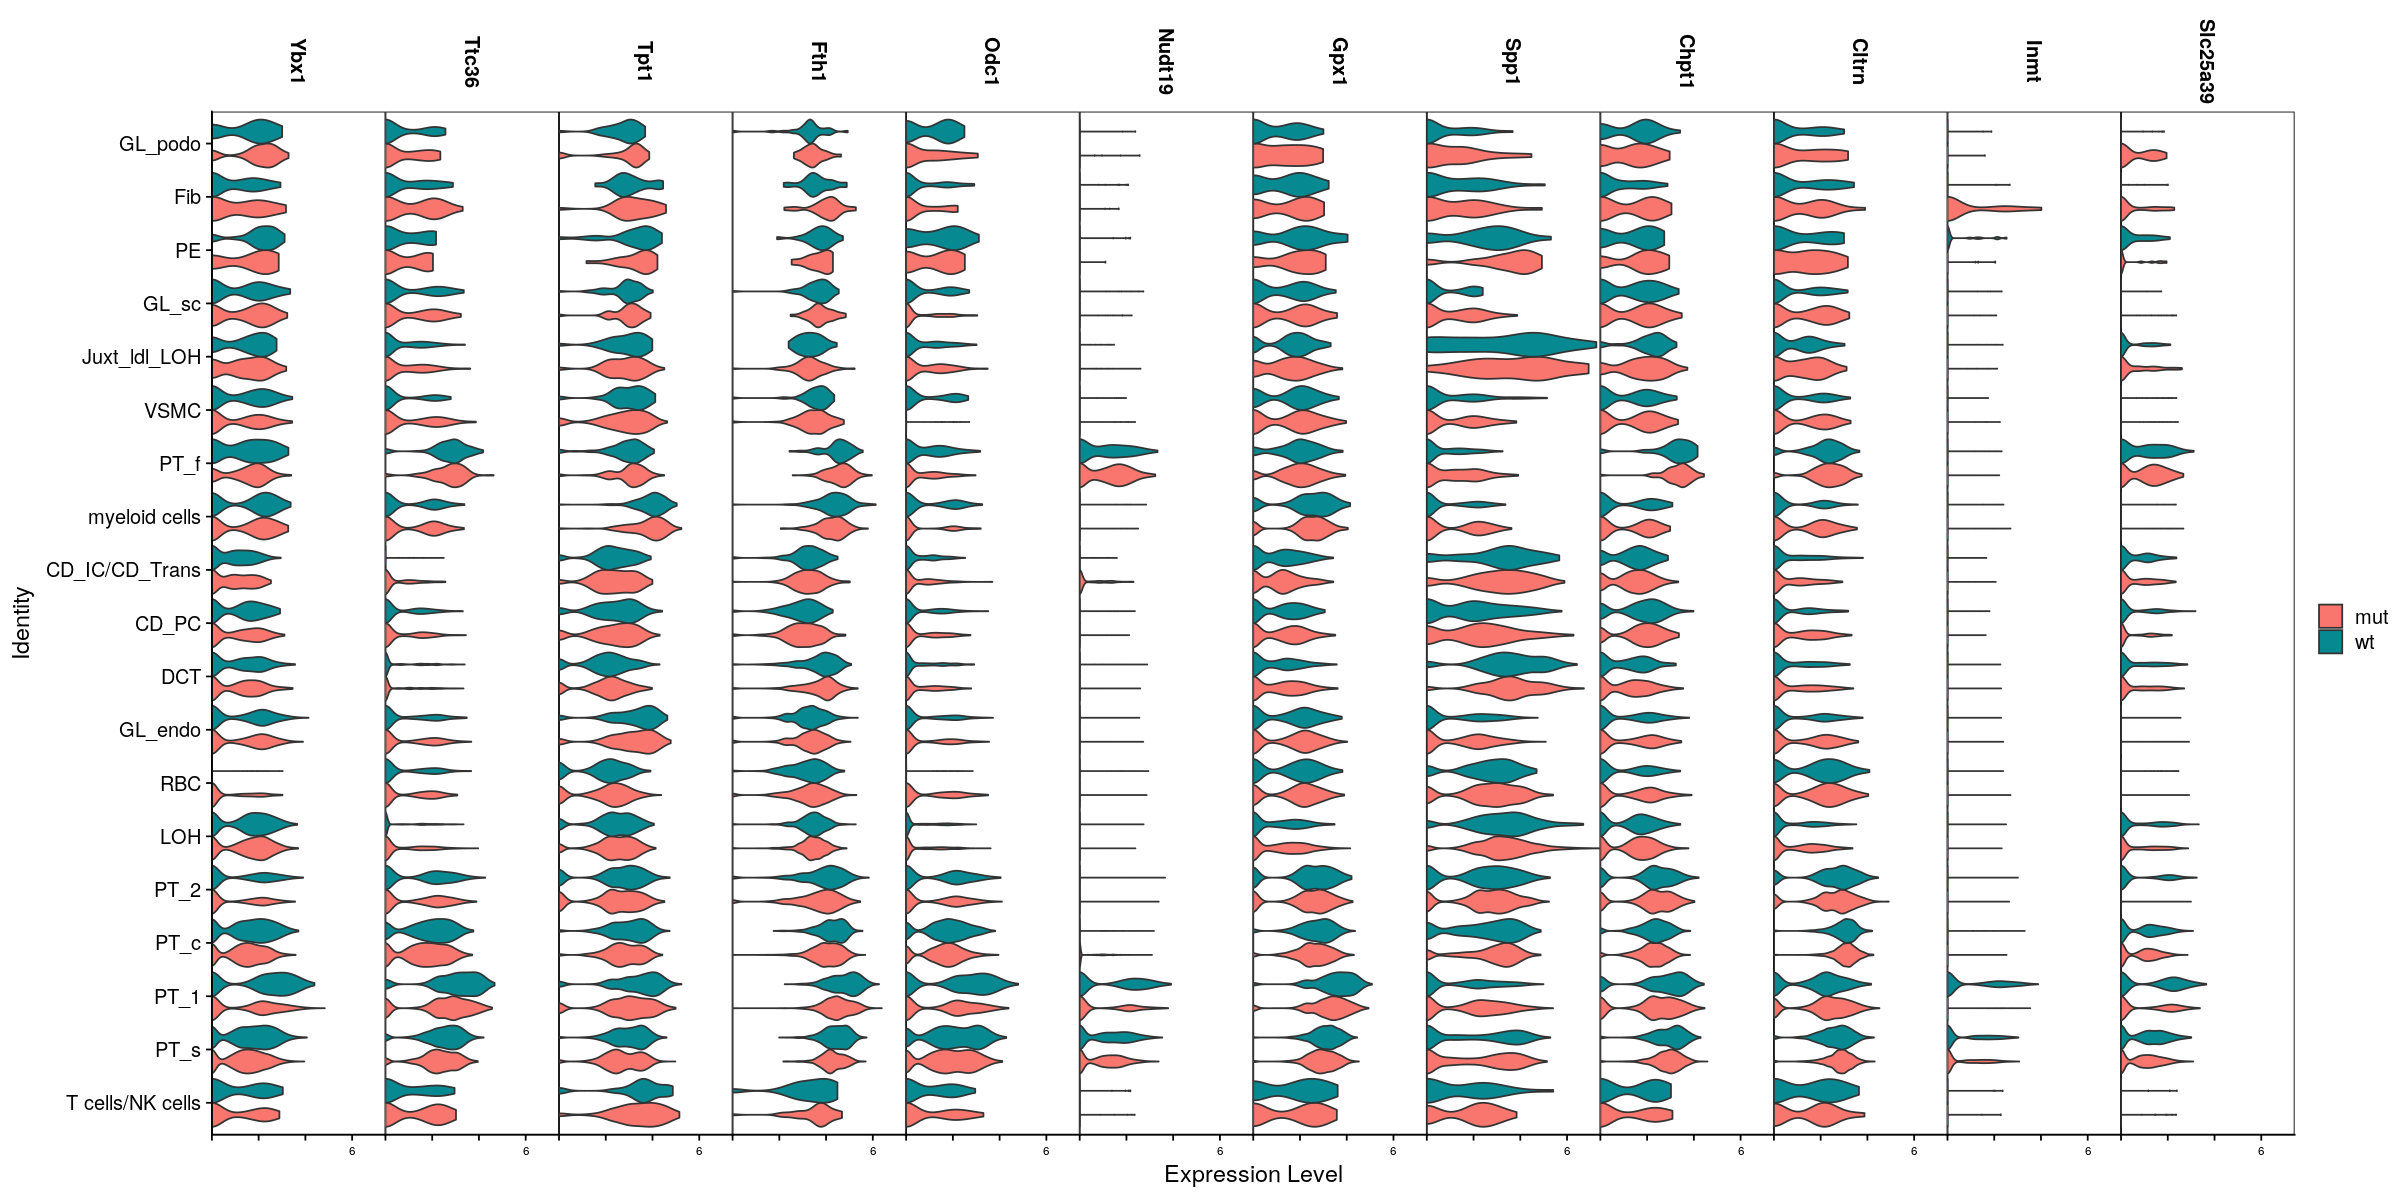

In [54]:
DefaultAssay(RIK.combined) <- "RNA"
 
VlnPlot(RIK.combined, features = c("Ybx1", "Ttc36", "Tpt1", "Fth1", "Odc1", "Nudt19", "Gpx1", "Spp1", "Chpt1", "Cltrn", "Inmt", "Slc25a39"), split.by = "type", 
    same.y.lims = TRUE, stack = TRUE, pt.size = 1, combine = FALSE)

Saving

In [ ]:
save(RIK.combined, file = 'wt_mut.rds')

write.table(RIK.combined@meta.data, file='/home/irina/RIK/annotation.tsv', quote=FALSE, sep='\t', col.names = NA)
write.table(RIK.combined@assays$RNA@counts, file="count_matrix.tsv", quote=FALSE, sep='\t', col.names = NA)
write.csv(Embeddings(RIK.combined, reduction = "umap"), file = "UMAP_embedding.csv")
